In [69]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import os
import this

# говорит, что мы хотим, чтобы графики сразу рисовались в юпитер ноутуке 
%matplotlib inline 

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [23]:
# Создаем датафреймы с данными
reg_data = pd.DataFrame({
'reg_ts': ['911382223', '932683089', '947802447','959523541', '969103313'],
'uid': [1, 2, 3, 4, 5]
})
reg_data

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [24]:
auth_data = pd.DataFrame({
'auth_ts': ['911382223', '932683089', '932921206', '933393015', '933875379'],
'uid': [1, 2, 2, 2, 2]
})
auth_data

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [25]:
# Объединяем данные по идентификатору пользователя
merged_data = pd.merge(reg_data, auth_data, on='uid', how='inner')
# Меняем порядок столбцов в датафрейме
merged_data = merged_data.reindex(columns=['uid', 'reg_ts', 'auth_ts'])
merged_data

,uid,reg_ts,auth_ts
0,1,911382223,911382223
1,2,932683089,932683089
2,2,932683089,932921206
3,2,932683089,933393015
4,2,932683089,933875379


In [26]:
# Преобразуем столбцы с временем в формат даты
merged_data['reg_ts'] = pd.to_datetime(merged_data['reg_ts'], unit='s')
merged_data['auth_ts'] = pd.to_datetime(merged_data['auth_ts'], unit='s')
merged_data

,uid,reg_ts,auth_ts
0,1,1998-11-18 09:43:43,1998-11-18 09:43:43
1,2,1999-07-22 22:38:09,1999-07-22 22:38:09
2,2,1999-07-22 22:38:09,1999-07-25 16:46:46
3,2,1999-07-22 22:38:09,1999-07-31 03:50:15
4,2,1999-07-22 22:38:09,1999-08-05 17:49:39


In [27]:
merged_data.dtypes

uid                 int64
reg_ts     datetime64[ns]
auth_ts    datetime64[ns]
dtype: object

In [28]:
merged_data['reg_ts'].agg(['min','max'])

min   1998-11-18 09:43:43
max   1999-07-22 22:38:09
Name: reg_ts, dtype: datetime64[ns]

In [29]:
merged_data

,uid,reg_ts,auth_ts
0,1,1998-11-18 09:43:43,1998-11-18 09:43:43
1,2,1999-07-22 22:38:09,1999-07-22 22:38:09
2,2,1999-07-22 22:38:09,1999-07-25 16:46:46
3,2,1999-07-22 22:38:09,1999-07-31 03:50:15
4,2,1999-07-22 22:38:09,1999-08-05 17:49:39


In [30]:
def calculate_retention(merged_data: pd.DataFrame, days: list) -> list:
  
   # Рассчитываем количество дней от начальной даты для каждой строки
    merged_data['day'] = (merged_data['auth_ts'] - merged_data['reg_ts']).dt.days
    
    # Создаем список для хранения classic retention на каждый день
    retention = []
    
    # Рассчитываем retention для каждого дня
    for day in days:        
        # Выбираем пользователей, вернувшихся в день `day`
        users_with_day = merged_data[(merged_data['day'] == day)]['uid'].unique()
        
        # Рассчитываем retention для дня `day`
        retention.append(len(users_with_day) / len(merged_data['uid'].unique()))
    
    return retention

In [55]:
def plt_show(days: list, retention: list, xs: list, title: str):
    plt.figure(figsize=(12, 4))
    plt.plot(days, retention)

    plt.title(title)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    plt.gca().set(xlabel='Days', ylabel='% Retaining Users')
    plt.ylim(0, 1.05)

    for x in xs:
        if x % 30 == 0:
            plt.vlines(x=days[x], ymin=0, ymax=retention[x], linestyles='dotted')
            plt.text(x=days[x], y=retention[x] + 0.05, s='{:.0%} (day {})'.format(retention[x], x))

    plt.show()

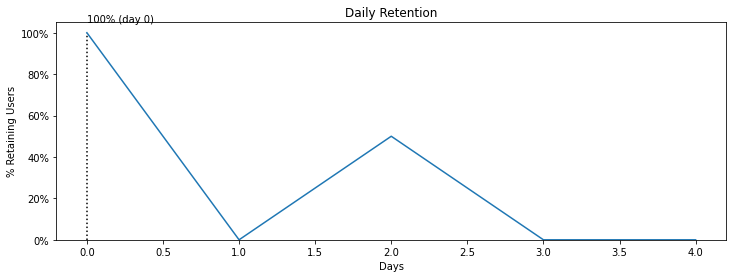

In [56]:
n = 5
days = list(range(0, n))
retention = calculate_retention(merged_data, days)

xs = list(range(len(days)))  # Подсветить все дни на графике
plt_show(days, retention, xs, title='Daily Retention')

In [57]:
merged_data

,uid,reg_ts,auth_ts,day
0,1,1998-11-18 09:43:43,1998-11-18 09:43:43,0
1,2,1999-07-22 22:38:09,1999-07-22 22:38:09,0
2,2,1999-07-22 22:38:09,1999-07-25 16:46:46,2
3,2,1999-07-22 22:38:09,1999-07-31 03:50:15,8
4,2,1999-07-22 22:38:09,1999-08-05 17:49:39,13


In [75]:
df = merged_data.loc[:, ['reg_ts', 'auth_ts', 'uid']]
df

,reg_ts,auth_ts,uid
0,1998-11-18 09:43:43,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,1999-07-22 22:38:09,2
2,1999-07-22 22:38:09,1999-07-25 16:46:46,2
3,1999-07-22 22:38:09,1999-07-31 03:50:15,2
4,1999-07-22 22:38:09,1999-08-05 17:49:39,2


In [78]:
df = merged_data.loc[:, ['reg_ts', 'auth_ts', 'uid']]
df

# Рассчет Retention
day_counts = (df.groupby((df['auth_ts'] - df['reg_ts']).dt.days)['uid'].nunique()
              .reindex(range(8), fill_value=0))
retention = (day_counts / day_counts[0] * 100).astype(int)

# Создание нового датафрейма с результатами
result = pd.DataFrame({'Day': range(8), 'uid': day_counts, 'Retention': retention})
result

# Транспонирование датафрейма result
result_transposed = result.set_index('Day').T

result_transposed

,Day,uid,Retention
0,0,2,100
1,1,0,0
2,2,1,50
3,3,0,0
4,4,0,0
5,5,0,0
6,6,0,0
7,7,0,0


In [79]:
# Транспонирование датафрейма result
result_transposed = result.set_index('Day').T

result_transposed

Day,0,1,2,3,4,5,6,7
uid,2,0,1,0,0,0,0,0
Retention,100,0,50,0,0,0,0,0


In [21]:
transaction_data_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-chernolihova/shared/homeworks/python_ds_miniprojects/5/transaction_data.csv')
transaction_data_1

,date,name,transaction
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled
1,2020-03-02 00:59:09,Irina_Fedorova,successfull
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled
...,...,...,...
5310,2020-03-02 00:09:28,Vasilisa_Fedorova,successfull
5311,2020-03-02 00:46:31,Vasilisa_Ozerova,successfull
5312,2020-03-02 00:16:38,Olga_Polyanova,successfull
5313,2020-03-02 00:13:00,Ekaterina_Smirnova,successfull


In [22]:
transaction_data_1.shape

(5315, 3)

In [23]:
transaction_data_1.dtypes

date           object
name           object
transaction    object
dtype: object

In [24]:
transaction_data_1.describe()

,date,name,transaction
count,5315,5315,5315
unique,3373,56,3
top,2020-03-02 00:33:10,Masha_Ozerova,successfull
freq,6,112,3692


In [25]:
transaction_data_1.isna().sum()

date           0
name           0
transaction    0
dtype: int64

In [26]:
kinds_trans = transaction_data_1.groupby('transaction', as_index=False) \
    .agg({'name': 'count'}) 
kinds_trans

,transaction,name
0,cancelled,1619
1,error,4
2,successfull,3692


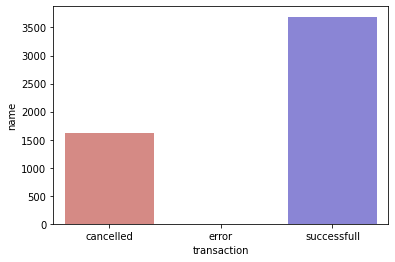

In [8]:
sns.barplot(x='transaction', y='name', data=kinds_trans, palette='hls', alpha=0.8)

In [27]:
successfull_trans = transaction_data_1.query("transaction == 'successfull'") \
    .groupby('name', as_index=False) \
    .agg({'date':'count'}) \
    .rename(columns = {'date': 'quantity_trans'})
successfull_trans.head()

,name,quantity_trans
0,Ekaterina_Fedorova,72
1,Ekaterina_Ivanova,59
2,Ekaterina_Lesnova,63
3,Ekaterina_Ozerova,72
4,Ekaterina_Petrova,68


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


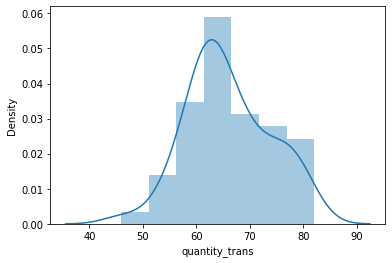

In [28]:
sns.distplot(successfull_trans.quantity_trans)

In [29]:
successfull_trans.describe()

,quantity_trans
count,56.000000
mean,65.928571
std,7.787769
min,46.000000
25%,61.000000
50%,64.000000
75%,72.000000
max,82.000000


In [86]:
transaction_data_updated = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-chernolihova/Untitled Folder/transaction_data_updated.csv')
transaction_data_updated

,date,name,transaction,minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17
...,...,...,...,...
5310,2020-03-02 00:09:28,Vasilisa_Fedorova,successfull,9
5311,2020-03-02 00:46:31,Vasilisa_Ozerova,successfull,46
5312,2020-03-02 00:16:38,Olga_Polyanova,successfull,16
5313,2020-03-02 00:13:00,Ekaterina_Smirnova,successfull,13


In [87]:
user_vs_minute_pivot = transaction_data_updated.groupby(['name', 'minute']) \
    .agg({'transaction': 'count'}) \
    .reset_index() \
    .pivot(index='minute', columns='name', values='transaction') \
    .fillna(0)

user_vs_minute_pivot.head()

name,Ekaterina_Fedorova,Ekaterina_Ivanova,Ekaterina_Lesnova,Ekaterina_Ozerova,Ekaterina_Petrova,Ekaterina_Polyanova,Ekaterina_Smirnova,Irina_Fedorova,Irina_Ivanova,Irina_Lesnova,...,Svetlana_Petrova,Svetlana_Polyanova,Svetlana_Smirnova,Vasilisa_Fedorova,Vasilisa_Ivanova,Vasilisa_Lesnova,Vasilisa_Ozerova,Vasilisa_Petrova,Vasilisa_Polyanova,Vasilisa_Smirnova
minute,,,,,,,,,,,,,,,,,,,,,
0,3.0,4.0,2.0,3.0,4.0,4.0,2.0,1.0,2.0,2.0,...,0.0,3.0,1.0,1.0,4.0,1.0,3.0,0.0,0.0,1.0
1,4.0,4.0,0.0,4.0,2.0,5.0,4.0,4.0,4.0,3.0,...,4.0,5.0,3.0,2.0,3.0,3.0,0.0,0.0,3.0,2.0
2,1.0,2.0,4.0,4.0,2.0,1.0,3.0,2.0,3.0,3.0,...,4.0,1.0,3.0,3.0,0.0,1.0,2.0,1.0,3.0,1.0
3,3.0,0.0,2.0,0.0,5.0,2.0,1.0,3.0,2.0,2.0,...,1.0,5.0,5.0,2.0,4.0,0.0,3.0,4.0,1.0,0.0
4,3.0,0.0,0.0,3.0,1.0,1.0,2.0,3.0,2.0,1.0,...,1.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,0.0,1.0


In [88]:
df = transaction_data_updated 
df.head()

,date,name,transaction,minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17


In [89]:
df['date'] = pd.to_datetime(df['date'])

In [90]:
df.dtypes

date           datetime64[ns]
name                   object
transaction            object
minute                  int64
dtype: object

In [91]:
df.insert(4, 'true_minute', df.date.dt.hour * 60 + df.date.dt.minute)

In [92]:
df.head()

,date,name,transaction,minute,true_minute
0,2020-03-02 00:37:20,Ekaterina_Petrova,cancelled,37,37
1,2020-03-02 00:59:09,Irina_Fedorova,successfull,59,59
2,2020-03-02 01:06:14,Ekaterina_Smirnova,successfull,6,66
3,2020-03-02 00:02:58,Lolita_Polyanova,cancelled,2,2
4,2020-03-02 00:17:52,Julia_Smirnova,cancelled,17,17


In [104]:
df.groupby('true_minute', as_index=False).agg({'transaction': 'count'})

,true_minute,transaction
0,0,64
1,1,77
2,2,68
3,3,65
4,4,57
...,...,...
85,85,68
86,86,52
87,87,59
88,88,62


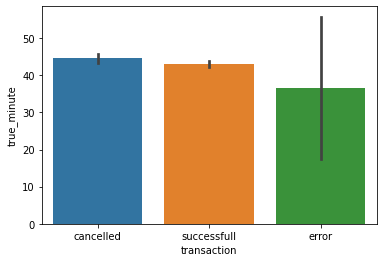

In [106]:
sns.barplot(x='transaction', y='true_minute', data=df)